## 1. Setup

The tool was developped based on the following dependencies:

1. PyTorch (1.1 or later).
2. NumPy (1.16 or later).
3. tqdm (4.31 or later).

Please note that the dependencies may require Python version greater than or equal to 3.6. It is recommemded to install and maintain all dependencies by using [`conda`](https://www.anaconda.com/) or [`pip`](https://pypi.org/project/pip/). For PyTorch installation, especially when GPU acceleration is needed, additional effort may be required. Please check the official websites of [PyTorch](https://pytorch.org/get-started/locally/) and [CUDA](https://developer.nvidia.com/cuda-downloads) for detailed instructions.

## 2. How to Use

After all dependencies being resolved, no installation is further required. You can use the tool either through command-line or function calls in your code.

### 2.1 Data format

All antibody protein sequences must be stored in plain-text format. A sequence consists of 20 amino acid symbol letters along with `"-"` to indicate gap. Sequences are deliminated by one single line-break. Please do not include spaces or extra line-breaks which will somehow confuse the program. The following lines show what the data is supposed to look like. Also, you can find sample data files under `<tool root>/data/sample/`

```
-QVQLVQS-GAEVKKPGSSVKVSCTTSG-GTFSS-----FVINWMRQAPGQGLGWRGGIMPV---
-EVQLLES-GGGLVQPGGSLRLSCAGSG-FTFSS-----YAMSWVRQTPGKGLEWVSVISGS---
-QVQLVES-GGGVVQSGRSLRLSCAASG-FTFRS-----HAIHWVGQAPGKGLEGVGVMSHD---
-QVHLVQS-GAEVHKPGASLRISCKASG-YTFPN-----FFLHWVRQAPGQGLEWMGIINPI---
-QVQLQES-GPGLMKPSGTLSLTCDVSG-ASISN----TNWWGWVRQPPGLGLEWIGEIHH----
```

If you want to generate data using Windows notepad, please be careful what the underlying line-break symbol is. 

### 2.2 Through function calls

### 2.2.1 Initialize

LSTM model is initialized by calling `model.ModelLSTM.__init__()` which takes 5 parameters:

1. `embedding_dim`: Embedding layer dimensions.
2. `hidden_dim`: Hiddden layer dimensions.
3. `device`: Device that the model will be mounted on.
4. `gapped`: Indicate whether the input sequences contains gaps.
5. `fixed_len`: Indicate whether the input sequences share equal length.

In [ ]:
from model import ModelLSTM

# initialize model
model = ModelLSTM(embedding_dim=64, hidden_dim=64, device='cuda:0', gapped=True, fixed_len=True)
print('Model initialized.')

### 2.2.2 Train

`model.ModelLSTM.fit()` fits the model via the given training and validation data. It has 8 parameters:
1. `trn_fn`: Data file for training.
2. `vld_fn`: Data file for validation.
3. `n_epoch`: Number of epochs.
4. `trn_batch_size`: Batch size during training. `-1` means whole batch.
5. `vld_batch_size`: Batch size during validation. `-1` means whole batch.
6. `lr`: Learning rate.
7. `save_model`: Path to save models. `None` means training without saving.
8. `n_iter_per_print`: Interval of displaying training statistics.

If GPU is available and CUDA is correctlly installed, you can assign `device` to be `"cuda:0"` (or `"cuda:1"` and so on if you have more GPUs) that will greatly accelerate the training process. For `fixed_len`, you can set it `False` without any issue, but when the sequence lengths are assured to be the same, setting it `True` will help accelerate the computation as well.

In [ ]:
# tell tqdm that it's running in jupyter notebook environment
model._tqdm_mode('tqdm_notebook')

# data file names
trn_fn = './data/sample/human_train.txt'
vld_fn = './data/sample/human_val.txt'

# fit model
model.fit(trn_fn=trn_fn, vld_fn=vld_fn, n_epoch=2, trn_batch_size=1024, vld_batch_size=1024, lr=.002,
          save_model=None, n_iter_per_print=100)

### 2.2.3 Evaluate

`model.ModelLSTM.eval()` scores the given sequences. It takes 2 parameters.

1. `fn`: Data file for evaluation.
2. `batch_size`: Batch size. -1 means whole batch.

The method returns:

1. 1-D NumPy array consists of all sequences' scores. Order is preserved.

To maximize evaluation speed, batch size is prefered to be as large as possible, but if there is any memory or GPU memory issue, please reduce the batch size.

In [ ]:
# data file names
human_tst_fn = './data/sample/human_test.txt'
mouse_tst_fn = './data/sample/mouse_test.txt'

# evaluate
print('Evaluating human sequences...')
human_tst_scores = model.eval(fn=human_tst_fn, batch_size=1024)
print('Evaluating mouse sequences...')
mouse_tst_scores = model.eval(fn=mouse_tst_fn, batch_size=1024)

Let's visualize the result.

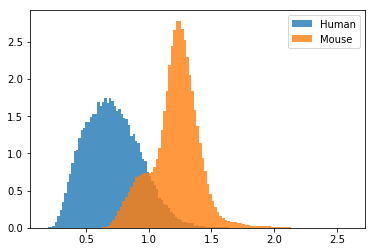

In [16]:
import matplotlib.pyplot as plt
plt.hist(human_tst_scores, bins=100, alpha=0.8, density=True, label='Human')
plt.hist(mouse_tst_scores, bins=100, alpha=0.8, density=True, label='Mouse')
plt.legend()
plt.show()

### 2.2.4 Save & Load

`model.ModelLSTM.save()` has 1 parameter.

1. `fn`: Save file name.

`model.ModelLSTM.load()` has 1 parameter and returns the loaded model.

1. `fn`: Load file name.

Please note that when `load()` method is invoked, all parameters will be overloaded and `device` will be reset to `"cpu"`. You may call `to()` method to switch among different devices.

`model.ModelLSTM.to()` has 1 parameter.

1. `device`: Device to mount.

### 2.3 Through command-line